In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

!tar xvf VOCtrainval_06-Nov-2007.tar
!tar xvf VOCtest_06-Nov-2007.tar 

!rm VOCtrainval_06-Nov-2007.tar
!rm VOCtest_06-Nov-2007.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/000725.jpg
VOCdevkit/VOC2007/JPEGImages/000727.jpg
VOCdevkit/VOC2007/JPEGImages/000732.jpg
VOCdevkit/VOC2007/JPEGImages/000734.jpg
VOCdevkit/VOC2007/JPEGImages/000735.jpg
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/

VOCdevkit/VOC2007/ has
- <b>Annotations:-</b>It has .xml files that contain the description of the objects in the image. There is one xml file for each image.
- <b>ImageSets</b>
  - <b>Layout</b>
    - test.txt
	- train.txt
	- trainval.txt
	- val.txt
  - <b>Main:-</b>It has the following set of files for each class. These are for object detection task.
    - horse_test.txt
	- horse_train.txt
	- horse_trainval.txt
	- horse_val.txt
	.
	.
	.
	- train.txt
	- test.txt
	- val.txt
	- trainval.txt
  - <b>Segmentation:-</b>It has the following set of files. These are for semantic segmentation task
    - test.txt
    - train.txt
	- trainval.txt
	- val.txt
- <b>JPEGImages:-</b>It has .jpg images
- <b>SegmentationClass:-</b>These have .png images with class segmentation.
- <b>SegmentationObject:-</b>These have .png images with object segmentation.

In [ ]:
import csv
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import torch
import torchvision 
from tqdm import tqdm
import torch.nn as nn
from torchsummary import summary
from torchvision.transforms import Resize
from torch.utils.data import DataLoader
from PIL import Image

##Setting the device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_detect_anomaly(True)

# Preprocess data

In [ ]:
classes = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 
           'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 
           'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 
           'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

for grp in ['train','test','val']:

  rows = [['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'cls_id']]
    
  with open(f'VOCdevkit/VOC2007/ImageSets/Main/{grp}.txt', 'r') as file:
    img_ids = [img_id.strip() for img_id in file.read().strip().split('\n')]
    
    for img_id in img_ids:
    
      filename = f'VOCdevkit/VOC2007/JPEGImages/{img_id}.jpg'
      xml = f'VOCdevkit/VOC2007/Annotations/{img_id}.xml'
      tree = ET.parse(xml)
      root = tree.getroot()
    
      for obj in root.findall('object'):
            
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        keys = set(classes.keys())
        if cls in keys and int(difficult) != 1:
          cls_id = classes[cls]
          box = obj.find('bndbox')
          xmin = int(box.find('xmin').text)
          ymin = int(box.find('ymin').text)
          xmax = int(box.find('xmax').text)
          ymax = int(box.find('ymax').text)
          rows.append([filename, xmin, ymin, xmax, ymax, cls_id])
        else:continue
        
  with open(f'VOCdevkit/VOC2007/{grp}.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

In [ ]:
train = pd.read_csv('VOCdevkit/VOC2007/train.csv')
train['cls_id'].value_counts().sort_index()

0      151
1      176
2      243
3      140
4      253
5      115
6      625
7      186
8      400
9      136
10     103
11     253
12     182
13     167
14    2358
15     248
16     130
17     124
18     145
19     166
Name: cls_id, dtype: int64

In [ ]:
val = pd.read_csv('VOCdevkit/VOC2007/val.csv')
val ['cls_id'].value_counts().sort_index()

0      155
1      177
2      243
3      150
4      252
5      114
6      625
7      190
8      398
9      123
10     112
11     257
12     180
13     172
14    2332
15     266
16     127
17     124
18     152
19     158
Name: cls_id, dtype: int64

In [ ]:
test = pd.read_csv('VOCdevkit/VOC2007/test.csv')
test['cls_id'].value_counts().sort_index()

0      285
1      337
2      459
3      263
4      469
5      213
6     1201
7      358
8      756
9      244
10     206
11     489
12     348
13     325
14    4528
15     480
16     242
17     239
18     282
19     308
Name: cls_id, dtype: int64

In [ ]:
train.head()

,filename,xmin,ymin,xmax,ymax,cls_id
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,156,97,351,270,6
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,185,62,279,199,14
2,VOCdevkit/VOC2007/JPEGImages/000017.jpg,90,78,403,336,12
3,VOCdevkit/VOC2007/JPEGImages/000023.jpg,9,230,245,500,1
4,VOCdevkit/VOC2007/JPEGImages/000023.jpg,230,220,334,500,1


## Prepare train and validation sets

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

with open('VOCdevkit/VOC2007/train.csv', 'r') as file:
  train_reader = csv.reader(file)
  next(train_reader)
  for line in train_reader:
    x_train.append(line[0])
    y_train.append([int(value) for value in line[1:]])

with open('VOCdevkit/VOC2007/val.csv', 'r') as file:
  val_reader = csv.reader(file)
  next(val_reader)
  for line in val_reader:
    x_val.append(line[0])
    y_val.append([int(value) for value in line[1:]])

## Custom Dataset Class

In [ ]:
class Dataset(torch.utils.data.Dataset) :

  def __init__(self, images, labels):    
    self.images = images
    self.labels = labels
  
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    img_path = self.images[idx]
    label = self.labels[idx]

    image = torchvision.io.read_image(img_path)
    height, width = image.shape[1:]
    image = torchvision.transforms.ToPILImage()(image)
    image = torchvision.transforms.Resize((448,448))(image)
    image = torchvision.transforms.ToTensor()(image)
    image = image/255
    label_matrix = torch.zeros((30,7,7))
  
    x_min = label[0]
    y_min = label[1]
    x_max = label[2]
    y_max = label[3]
    clss = label[4]
    x = (x_min+x_max)/2/width
    y = (y_min+y_max)/2/height   
    w = (x_max-x_min)/width
    h = (y_max-y_min)/height
    loc = [7*x, 7*y]
    loc_y = int(loc[1])
    loc_x = int(loc[0])
    x = loc[0] - loc_x
    y = loc[1] - loc_y
  
    # note:- these are matrix co-ordinates
    label_matrix[20:25, loc_y, loc_x] = torch.tensor([1, x, y, w, h])
    label_matrix[clss, loc_y, loc_x] = 1

    return image, label_matrix

##Network

###Model

In [ ]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.leakyrelu = nn.LeakyReLU(0.1)
  
  def forward(self, x):
    return self.leakyrelu(self.conv(x))

class YoloV1(nn.Module):
  def __init__(self, architecture):
    super(YoloV1, self).__init__()
    self.darknet = self._create_layers(architecture)
      
  def forward(self, x):
    return self.darknet(x)
      
  def _create_layers(self, architecture, in_channels=3):
    layers = []
    #architecture should have two parts. First part should contain conv layers and second part should contain linear layers.
    for x in architecture[0]:
      if type(x) == tuple:
        layers.append(CNNBlock(in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[0]//2))
        in_channels = x[1]
      elif type(x) == str:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      elif type(x) == list:
        for y in range(x[-1]):
          for z in x[:-1]:
            layers.append(CNNBlock(in_channels, out_channels=z[1], kernel_size=z[0], stride=z[2], padding=z[0]//2))
            in_channels = z[1]
    
    layers.append(nn.Flatten())
    in_features = architecture[1][0]
    for x in architecture[1][1:]:
      layers.append(nn.Linear(in_features, x))
      in_features = x
      
    return nn.Sequential(*layers)

###Loss

In [ ]:
class YoloLoss(nn.Module):

  def __init__(self, S=7, B=2, C=20):
    super(YoloLoss, self).__init__()
    self.S = S
    self.B = B
    self.C = C
    self.lambda_coord = 0.5
    self.lambda_noobj = 5
  
  #pred and true are (m,30,s,s) tensors
  def forward(self, pred, true):
    pred = torch.reshape(pred,(-1, self.B*5+self.C, self.S, self.S))
    true = torch.reshape(true,(-1, self.B*5+self.C, self.S, self.S))
    iou_b1 = IOU(yolo_to_pixels(pred[:,21:25,:,:]), yolo_to_pixels(true[:,21:25,:,:]))
    iou_b2 = IOU(yolo_to_pixels(pred[:,26:30,:,:]), yolo_to_pixels( true[:,21:25,:,:]))
    ious = torch.cat([iou_b1, iou_b2], dim=1)                         #ious is an (m,2,s,s) tensor
    iou_maxes, best_box = torch.max(ious, dim=1, keepdim=True)        #iou_maxes and best_box are (m,1,s,s) tensors
    exists_box = true[:,20:21,:,:]                                    #exists_box is an (m,1,s,s) tensor
    
    #box loss
    #box_true and box_pred are (m, 4, s, s) tensors
    box_pred = exists_box * (best_box*pred[:,26:30,:,:]+(1-best_box)*pred[:,21:25,:,:])
    box_pred[:,2:,:,:] = torch.sign(box_pred[:,2:,:,:])*torch.sqrt(torch.abs(box_pred[:,2:,:,:]+1e-6))
    box_true = exists_box * true[:,21:25,:,:]
    box_true[:,2:,:,:] = torch.sqrt(box_true[:,2:,:,:])
    diff_box = box_true-box_pred
    box_loss = torch.sum(torch.square(diff_box))
    
    #object loss
    obj_pred = exists_box*(best_box*pred[:,25:26,:,:]+(1-best_box)*pred[:,20:21,:,:])
    obj_true = exists_box * true[:,20:21,:,:]
    diff_obj = obj_true-obj_pred
    obj_loss = torch.sum(torch.square(diff_obj))
    
    #no object loss
    noobj_pred = (1-exists_box) * ((pred[:,25:26,:,:]+pred[:,20:21,:,:])/2)
    noobj_true = (1-exists_box) * true[:,20:21,:,:]
    diff_noobj = noobj_true-noobj_pred
    noobj_loss = torch.sum(torch.square(diff_noobj))
    
    #class loss
    class_pred = exists_box * pred[:,:20,:,:]
    class_true = exists_box * true[:,:20,:,:]
    diff_class = class_true-class_pred
    class_loss = torch.sum(torch.square(diff_class))
    
    #total loss
    loss = self.lambda_coord*box_loss + obj_loss + self.lambda_noobj*noobj_loss + class_loss
    
    return loss

###Helper Functions

In [ ]:
def yolo_to_pixels(boxes, S=7, N=448):
  new_boxes = boxes.clone().detach()
  x_ind_tensor = torch.reshape(torch.arange(0,7),(1,1,1,7)).to(device)
  y_ind_tensor = torch.reshape(torch.arange(0,7),(1,1,7,1)).to(device)
  new_boxes[:,0:1,:,:] = (new_boxes[:,0:1,:,:]!=0)*(x_ind_tensor+new_boxes[:,0:1,:,:])*(N/S)
  new_boxes[:,1:2,:,:] = (new_boxes[:,1:2,:,:]!=0)*(y_ind_tensor+new_boxes[:,1:2,:,:])*(N/S)
  new_boxes[:,2:4,:,:] = new_boxes[:,2:4,:,:]*N
  return new_boxes 

def pixels_to_yolo(img_paths, labels):
  yolo_images = []
  yolo_labels = []
  for img_path, label in zip(img_paths, labels):
    image = torchvision.io.read_image(img_path)
    height, width = image.shape[1:]
    image = torchvision.transforms.ToPILImage()(image)
    image = torchvision.transforms.Resize((448,448))(image)
    image = torchvision.transforms.ToTensor()(image)
    image = image/255
    label_matrix = torch.zeros((30,7,7))
    
    x_min = label[0]
    y_min = label[1]
    x_max = label[2]
    y_max = label[3]
    clss = label[4]
    x = (x_min+x_max)/2/width
    y = (y_min+y_max)/2/height   
    w = (x_max-x_min)/width
    h = (y_max-y_min)/height
    loc = [7*x, 7*y]
    loc_y = int(loc[1])
    loc_x = int(loc[0])
    x = loc[0] - loc_x
    y = loc[1] - loc_y
    
    # note:- these are matrix co-ordinates
    label_matrix[ 20:25, loc_y, loc_x] = torch.tensor([1, x, y, w, h])
    label_matrix[ clss, loc_y, loc_x] = 1
    
    yolo_images.append(image)
    yolo_labels.append(label_matrix)
  
  return torch.stack(yolo_images), torch.stack(yolo_labels)
#pred, true are of shape (m,4,s,s) with format [x_mid, y_mid, width, height]
def IOU(pred, true, S=7):
  #following are of shape (m,1,s,s)
  x_pred = pred[:,0:1,:,:]
  y_pred = pred[:,1:2,:,:]
  w_pred = pred[:,2:3,:,:]
  h_pred = pred[:,3:4,:,:]
  x_true = true[:,0:1,:,:]
  y_true = true[:,1:2,:,:]
  w_true = true[:,2:3,:,:]
  h_true = true[:,3:4,:,:]
  x_max = torch.max(x_pred-w_pred/2, x_true-w_true/2)
  y_max = torch.max(y_pred-h_pred/2, y_true-h_true/2)
  x_min = torch.min(x_pred+w_pred/2, x_true+w_true/2)
  y_min = torch.min(y_pred+h_pred/2, y_true+h_true/2)
  
  intersection = (x_min-x_max) * (y_min-y_max)
  union = w_pred * h_pred + w_true * h_true - intersection
  
  iou = intersection/union
  iou[iou!=iou] = 0

  return iou

def yolo_to_boxes(out, S=7, box_thre=0.9):
  #out is of shape (m,30,7,7)
  #boxes1, boxes2, boxes are of shape (m,4,7,7)
  boxes1 = out[:,21:25,:,:]
  boxes2 = out[:,26:30,:,:]
  prob_scores = torch.cat([out[:,20:21,:,:],out[:,25:26,:,:]],dim=1) #prob_scores is of shape (m,2,7,7)
  best_prob, best_box = torch.max(prob_scores, dim=1, keepdim=True)  #best_prob, best_box are of shape (m,1,7,7)
  boxes = boxes1*(1-best_box)+best_box*boxes2
  #clss is of shape (m,1,7,7)
  clss = torch.argmax(out[:,:20,:,:],dim=1,keepdim=True)
  bboxes = torch.cat([clss, best_prob, yolo_to_pixels(boxes)], dim=1)#bboxes is of shape (m,6,7,7)
  bboxes = torch.reshape(bboxes, (-1, 6, S*S))
  new_bboxes = {}
  
  for i in range(bboxes.shape[0]):
    new_bboxes[i]=[]
    for cell in range(bboxes.shape[-1]):
      temp=[]
      if bboxes[i,:,cell][1]>box_thre:
        for value in bboxes[i,:,cell]:
          temp.append(round(float(value),4))
        new_bboxes[i].append(temp)

  return new_bboxes

def iou(pred, true, S=7):
  #following are of shape (m,1,s,s)
  x_pred = pred[0]
  y_pred = pred[1]
  w_pred = pred[2]
  h_pred = pred[3]
  x_true = true[0]
  y_true = true[1]
  w_true = true[2]
  h_true = true[3]
  x_max = torch.max(x_pred-w_pred/2, x_true-w_true/2)
  y_max = torch.max(y_pred-h_pred/2, y_true-h_true/2)
  x_min = torch.min(x_pred+w_pred/2, x_true+w_true/2)
  y_min = torch.min(y_pred+h_pred/2, y_true+h_true/2)
  
  intersection = (x_min-x_max) * (y_min-y_max)
  union = w_pred * h_pred + w_true * h_true - intersection
  
  iou = intersection/union
  iou[iou!=iou] = 0

  return iou

#pred is of format {0:[[class, box_prob, x_mid, y_mid, width, height],...],...}
def NMS(pred, iou_thre=0.5):
  for key in pred:
    pred[key] = sorted(pred[key], key=lambda x:x[1], reverse=True)
  nms_boxes = {}
  
  for key in pred:
    nms_boxes[key] = []
    while pred[key]:
      chosen_box = pred[key].pop(0)
      pred[key] = [box 
                   for box in pred[key] 
                   if box[0]!=chosen_box[0] or
                   iou(torch.tensor(box),torch.tensor(chosen_box))<iou_thre]
      nms_boxes[key].append(chosen_box)

  return nms_boxes

def plot_image(boxes, img_path):
  size = 448
  image = cv.imread(img_path)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  image = cv.resize(image,(448,448))
  for box in boxes:
    cls = int(box[0])
    x = box[2]
    y = box[3]
    w = box[4]
    h = box[5]
    x_min = int(max(x-w/2,0))
    y_min = int(max(y-h/2,10))
    x_max = int(min(x+w/2,448))
    y_max = int(min(y+h/2,448))
    cv.rectangle(image,(x_min,y_min),(x_max,y_max),(255,255,255),2)
    cv.putText(image, list(classes.keys())[list(classes.values()).index(cls)], \
            (x_min, y_min-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
    plt.imshow(image) 

def MAP(pred, true, n_classes, iou_thresh=0.5):
  #pred, true are of format [idx, class, obj_prob, x1, y1, x2, y2]
  avg_prec = []
    
  for c in range(n_classes):
    predictions = []
    truths = []
        
    for prediction in pred:
      if prediction[1]==c:
        predictions.append(prediction)
        
      for truth in true:
        if truth[1]==c:
          truths.append(truth)
        
    boxes_per_img = Counter([truth[0] for truth in truths])
        
    for key, val in boxes_per_img.items():
      boxes_per_img[key] = torch.zeros(val)
            
      predictions.sort(key=lambda x:x[2], reverse=True)
      TP = torch.zeros(len(predictions))
      FP = torch.zeros(len(predictions))
      n_truths  = len(truths)
        
      for pred_idx, prediction in enumerate(predictions):
        truth_img = [truth for truth in truths if truth[0]==prediction[0]]
        n_truths_img = len(truth_img)
        best_iou = 0
            
        for idx, truth in enumerate(truth_img):
          iou = IOU(prediction[3:], truth[3:])
          if iou>best_iou:
            best_iou = iou
            best_truth_idx = idx
            
          if best_iou>iou_thresh:
            if boxes_per_img[prediction[0]][best_truth_idx]==0:
              TP[pred_idx]=1
              boxes_per_img[prediction[0]][best_truth_idx]=1
            else:
              FP[pred_idx]=1
          else:
            FP[pred_idx]=1
            
      TP_cumsum = torch.cumsum(TP, dim=0)
      FP_cumsum = torch.cumsum(FP, dim=0)
      recall = TP_cumsum/n_truths
      precision = TP_cumsum/(TP_cumsum+FP_cumsum)
      precision = torch.cat(torch.tensor([1]), precision)
      recall = torch.cat(torch.tensor([0]), recall)
      avg_prec.append(torch.trapz(precision,recall))
        
    return sum(avg_prec)/len(avg_prec)

def save_chkpt(model, optim, filename='drive/MyDrive/chkpt.pth.tar'):
  chkpt = {'state_dict':model.state_dict(),'optimizer':optim.state_dict()}
  torch.save(chkpt, filename)

def load_chkpt(model, optim, filename='drive/MyDrive/chkpt.pth.tar'):
  chkpt = torch.load(filename)
  model.load_state_dict(chkpt['state_dict'])
  optim.load_state_dict(chkpt['optimizer'])

##Training

###Architecture

In [ ]:
C = 20
S = 7
B = 2
N = 448

architecture = [[
#tuple : (kernel_size, n_filters, stride)
(7,64,2),
#M : maxpooling layer with kernel_size=2 and stride=2
'M',
(3,192,1),
'M',
(1,128,1),
(3,256,1),
(1,256,1),
(3,512,1),
'M',
#list : [tuples, repeat]
[(1,256,1),(3,512,1),4],
(1,512,1),
(3,1024,1),
'M',
[(1,512,1),(3,1024,1),2],
(3,1024,1),
(3,1024,2),
(3,1024,1),
(3,1024,1)],
[
# int : n_neurons
7*7*1024,
4096,
S*S*(C+B*5)
]]

In [ ]:
load_model = True
model = YoloV1(architecture).to(device)
yololoss = YoloLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

if load_model:
  load_chkpt(model, optimizer)

In [ ]:
summary(model,(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
         LeakyReLU-2         [-1, 64, 224, 224]               0
          CNNBlock-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 192, 112, 112]         110,784
         LeakyReLU-6        [-1, 192, 112, 112]               0
          CNNBlock-7        [-1, 192, 112, 112]               0
         MaxPool2d-8          [-1, 192, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          24,704
        LeakyReLU-10          [-1, 128, 56, 56]               0
         CNNBlock-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
        LeakyReLU-13          [-1, 256, 56, 56]               0
         CNNBlock-14          [-1, 256,

In [ ]:
epoch_losses = []
def fit(x_train, y_train, model, optimizer, epochs):
  train_set = Dataset(x_train, y_train)
  train_loader = DataLoader(train_set, 16, True)
  for epoch in range(epochs):
    batch_losses = []
    if epoch%1==0 and epoch!=0:
      save_chkpt(model, optimizer)
    loop = tqdm(train_loader,  position=0, leave=True)
    for x, y in loop:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = yololoss(y_hat, y)
      batch_losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loop.set_postfix(loss=loss)

    epoch_losses.append(sum(batch_losses)/len(batch_losses))
  return

In [ ]:
def predict(x_test, model):
  images = []
  for img_path in x_test:
    image = torchvision.io.read_image(img_path)
    height, width = image.shape[1:]
    image = torchvision.transforms.ToPILImage()(image)
    image = torchvision.transforms.Resize((448,448))(image)
    image = torchvision.transforms.ToTensor()(image)
    image = image/255
    images.append(image)
  
  y_hat = model(torch.stack(images))
  y_hat = torch.reshape(y_hat,(len(x_test),30,7,7))
 
  boxes = NMS(yolo_to_boxes(y_hat))
  return boxes

In [ ]:
fit(x_train,y_train,model,optimizer,10)

 38%|███▊      | 150/394 [1:42:36<2:43:09, 40.12s/it, loss=tensor(25.3803, grad_fn=<AddBackward0>)]

In [ ]:
  index = 0
x_test = ['VOCdevkit/VOC2007/JPEGImages/000017.jpg']
boxes = predict(x_test,model)
plot_image(boxes[0],x_test[0])

In [ ]:
size = 448
image = cv.imread(img_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image,(448,448))
for box in boxes[0]:
  cls = int(box[0])
  x = int(box[2])
  y = int(box[3])
  w = int(box[4])
  h = int(box[5])
  x_min = max(x-w/2,0)
  y_min = max(y-h/2,0)
  x_max = min(x+w/2,448)
  y_max = min(y+h/2,448)

In [ ]:
cv.rectangle(image,(x_min,y_min),(x_max,y_max),(255,255,255),2)

TypeError: ignored

In [ ]:
boxes[0]

[[7.0, 0.0, 0.3978, 44.774, 447.4505, 341.4242],
 [15.0, 0.0, 65.2183, 63.6471, 250.4317, 3.3848],
 [14.0, 0.0, 136.7449, 63.8993, 0.0, 445.8206],
 [2.0, 0.0, 319.3736, 0.2716, 323.6619, 50.758],
 [4.0, 0.0, 378.4474, 63.9778, 0.0023, 47.5018],
 [17.0, 0.0, 384.337, 0.0045, 415.5829, 438.8334],
 [18.0, 0.0, 0.0411, 123.9308, 447.5742, 394.9304],
 [16.0, 0.0, 83.9296, 64.059, 232.9476, 123.9557],
 [5.0, 0.0, 360.3449, 116.6105, 2.0827, 1.0103],
 [3.0, 0.0, 430.3725, 103.123, 447.3839, 3.345],
 [13.0, 0.0, 62.5739, 134.4058, 348.2971, 33.9849],
 [0.0, 0.0, 128.0202, 191.8702, 0.0094, 0.0007],
 [12.0, 0.0, 198.9509, 251.5436, 255.2432, 268.1351],
 [8.0, 0.0, 319.9986, 192.1055, 443.4434, 447.94],
 [9.0, 0.0, 97.532, 316.0651, 405.7234, 50.0993],
 [10.0, 0.0, 209.9063, 319.9934, 447.9858, 430.6108],
 [1.0, 0.0, 383.9997, 320.0147, 28.3649, 405.4191],
 [17.0, 0.0, 311.2124, 384.2139, 371.3922, 3.6749]]

In [ ]:
x_test = ['VOCdevkit/VOC2007/JPEGImages/000023.jpg']
images = []
for img_path in x_test:
  image = torchvision.io.read_image(img_path)
  height, width = image.shape[1:]
  image = torchvision.transforms.ToPILImage()(image)
  image = torchvision.transforms.Resize((448,448))(image)
  image = torchvision.transforms.ToTensor()(image)
  image = image/255
  images.append(image)

y_hat = model(torch.stack(images))
y_hat = torch.reshape(y_hat,(len(x_test),30,7,7))

In [ ]:
yolo_to_boxes(y_hat)

{0: [tensor([7.0000e+00, 0.0000e+00, 3.9780e-01, 4.4774e+01, 4.4745e+02, 3.4142e+02]),
  tensor([ 15.0000,   0.0000,  65.2183,  63.6471, 250.4317,   3.3848]),
  tensor([ 14.0000,   0.0000, 136.7449,  63.8993,   0.0000, 445.8206]),
  tensor([  7.0000,   0.0000, 233.6932,  62.0761, 105.2142,  17.0441]),
  tensor([2.0000e+00, 0.0000e+00, 3.1937e+02, 2.7160e-01, 3.2366e+02, 5.0758e+01]),
  tensor([4.0000e+00, 0.0000e+00, 3.7845e+02, 6.3978e+01, 2.3000e-03, 4.7502e+01]),
  tensor([1.7000e+01, 0.0000e+00, 3.8434e+02, 4.5000e-03, 4.1558e+02, 4.3883e+02]),
  tensor([1.8000e+01, 0.0000e+00, 4.1100e-02, 1.2393e+02, 4.4757e+02, 3.9493e+02]),
  tensor([ 16.0000,   0.0000,  83.9296,  64.0590, 232.9476, 123.9557]),
  tensor([  7.0000,   0.0000, 191.9962, 101.6258,  34.8000, 443.6122]),
  tensor([  7.0000,   0.0000, 192.1258, 101.1205,  10.8170, 228.5433]),
  tensor([ 18.0000,   0.0000, 256.0923, 116.9654, 298.1368, 445.4837]),
  tensor([  5.0000,   0.0000, 360.3449, 116.6105,   2.0827,   1.0103]),
 

In [ ]:
NMS(pred)

TypeError: ignored

In [ ]:
pred[0]

0

In [ ]:
new_boxes[:,0:1,:,:] = (new_boxes[:,0:1,:,:]!=0)*(x_ind_tensor+new_boxes[:,0:1,:,:])*(448/7)
new_boxes[:,1:2,:,:] = (new_boxes[:,1:2,:,:]!=0)*(y_ind_tensor+new_boxes[:,1:2,:,:])*(448/7)
new_boxes[:,2:4,:,:] = new_boxes[:,2:4,:,:]*448

In [ ]:
torch.max(new_boxes[:,0,:,:])

tensor(444.8897)

In [ ]:
train[train.iloc[:,0]=='VOCdevkit/VOC2007/JPEGImages/000100.jpg']

,filename,xmin,ymin,xmax,ymax,cls_id


In [ ]:
import matplotlib.pyplot as plt

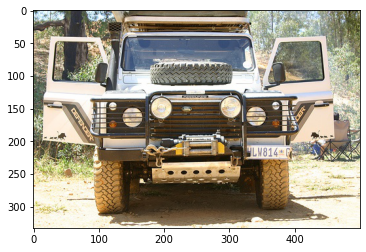

In [ ]:
image = mpimg.imread('VOCdevkit/VOC2007/JPEGImages/000047.jpg')
plt.imshow(image)

In [ ]:
import torch

In [ ]:
pred = torch.zeros((1,30,7,7))
pred[0,7,2,1] = 0.9
pred[0,20:25,2,1] = torch.tensor([0.9, 0.1, 0.5, 0.21, 0.11])
pred[0,25:30,2,1] = torch.tensor([0.85, 0.19, 0.39, 0.14, 0.11])
pred[0,12,3,5] = 0.79
pred[0,20:25,3,5] = torch.tensor([0.92, 0.22, 0.4, 0.37, 0.1])
pred[0,25:30,3,5] = torch.tensor([0.95, 0.19, 0.39, 0.36, 0.08])
true = torch.zeros((1,30,7,7))
true[0,7,2,1] = 1
true[0,20:25,2,1] = torch.tensor([1, 0.2, 0.47, 0.17, 0.09])
true[0,12,3,5] = 1
true[0,20:25,3,5] = torch.tensor([1, 0.19, 0.37, 0.42, 0.07])

In [ ]:
yololoss(pred, true)

tensor(0.0851)

In [ ]:
pred = model(x)

In [ ]:
pred = torch.reshape(pred,(-1,30,7,7))

In [ ]:
False in torch.isnan(pred)

False

In [ ]:
boxes={key:value for key, value in zip(boxes.keys(),boxes.values()) if value[1]>0.5}
sorted(boxes.items(),key=lambda x:x[1][0],reverse=True)

[(26, [12.0, 0.95, 332.16, 216.96, 161.28, 35.84]),
 (15, [7.0, 0.9, 70.4, 160.0, 94.08, 49.28])]

In [ ]:
sorted_boxes = {}
for key, value in sorted(boxes.items(),key=lambda x:x[1][1],reverse=True):
  sorted_boxes[key] = value
sorted_boxes

{15: [0.9, 0.9, 70.4, 160.0, 94.08, 49.28],
 26: [0.79, 0.95, 332.16, 216.96, 161.28, 35.84]}

In [ ]:
S=7
N=448
new_boxes = pred[:,21:25,:,:].clone().detach()
x_ind_tensor = torch.reshape(torch.arange(0,S),(1,1,1,7)).to(device)
y_ind_tensor = torch.reshape(torch.arange(0,S),(1,1,7,1)).to(device)
new_boxes[:,0:1,:,:] = (new_boxes[:,0:1,:,:]!=0)*(x_ind_tensor+new_boxes[:,0:1,:,:])*(N/S)
new_boxes[:,1:2,:,:] = (new_boxes[:,1:2,:,:]!=0)*(y_ind_tensor+new_boxes[:,1:2,:,:])*(N/S)
new_boxes[:,2:4,:,:] = new_boxes[:,2:4,:,:]*N
new_boxes

tensor([[[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,  70.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 334.0800,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000, 160.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 217.6000,   0.0000],
          [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  0

In [ ]:
#boxes1, boxes2 are of shape [m, 4, 7, 7]
boxes1 = pred[:,21:25,:,:]
boxes2 = pred[:,26:30,:,:]
prob_scores = torch.cat([pred[:,20:21,:,:],pred[:,25:26,:,:]],dim=1) #prob_scores are of shape [m, 2, 7, 7]
best_prob, best_box = torch.max(prob_scores, dim=1, keepdim=True)
boxes = boxes1*(1-best_box)+best_box*boxes2
#clss is of shape (m,1,7,7)
clss, _ = torch.max(pred[:,:20,:,:],dim=1,keepdim=True)
bboxes = torch.cat([clss, prob_scores, yolo_to_pixels(boxes)], dim=1)
bboxes = torch.reshape(bboxes, (1, 6, S*S))
new_bboxes = {}
i=0
for entry in range(bboxes.shape[0]):
  for cell in range(bboxes.shape[-1]):
    new_bboxes[i] = list(bboxes[entry,:,cell])
    i += 1
new_bboxes

RuntimeError: ignored

In [ ]:
boxes

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1900, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3900, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0

In [ ]:
 yololoss(pred, true)

tensor(0.0851)

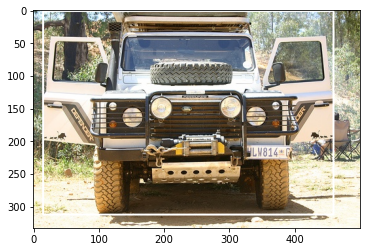

In [ ]:
index=25
img_path = x_train[index]
label = y_train[index]
size = 448
image = cv.imread(img_path)
height, width = image.shape[0:2]
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
x_min = label[0]
y_min = label[1]
x_max = label[2]
y_max = label[3]
cls = label[4]
cv.rectangle(image,(x_min,y_min),(x_max,y_max),(255,255,255),2)
cv.putText(image, list(classes.keys())[list(classes.values()).index(cls)], \
           (x_min, y_min-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
plt.imshow(image)

In [ ]:
image.shape

(333, 500, 3)

In [ ]:
S = 7
B = 2
C = 20
x = (x_min+x_max)/2/size
y = (y_min+y_max)/2/size
w = (x_max-x_min)/size
h = (y_max-y_min)/size
loc = [S*x, S*y]
loc_i = int(loc[1])
loc_j = int(loc[0])
x = loc[0] - loc_j
y = loc[1] - loc_i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


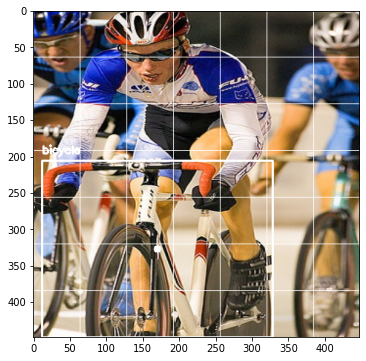

In [ ]:
grid_size = size//S
lines = []
for i in range(S):
    cv.line(image,(0,i*(grid_size)),(size,i*grid_size),(255,255,255))
    cv.line(image,(i*grid_size,0),(i*grid_size,size),(255,255,255))
cv.circle(image,(int((loc_j+x)*grid_size),int((loc_i+y)*grid_size)),5,(255,255,255),-1)
plt.imshow(image)

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)

In [ ]:
architecture = [[
#tuple : (kernel_size, n_filters, stride)
(7,64,2),
#M : maxpooling layer with kernel_size=2 and stride=2
'M',
(3,192,1),
'M',
(1,128,1),
(3,256,1),
(1,256,1),
(3,512,1),
'M',
#list : [tuples, repeat]
[(1,256,1),(3,512,1),4],
(1,512,1),
(3,1024,1),
'M',
[(1,512,1),(3,1024,1),2],
(3,1024,1),
(3,1024,2),
(3,1024,1),
(3,1024,1)],
[
# int : n_neurons
7*7*1024,
]]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Flatten, Reshape, ZeroPadding2D, Dense, Conv2D, MaxPool2D, LeakyReLU

B = 2
C = 20
S = 7
N = 448

class CNNBlock(tf.keras.layers.Layer):
    def __init__(self, padding, filters, kernel_size, strides, alpha):
        super(CNNBlock, self).__init__()
        self.pad = ZeroPadding2D(padding)
        self.conv = Conv2D(filters, kernel_size, strides)
        self.relu = LeakyReLU(alpha)
        
    def call(self, x):
        return self.relu(self.conv(self.pad(x)))

class Yolov1:
  def __init__(self, architecture, B, C, S, alpha):
    super(Yolov1, self).__init__()
    self.B = B
    self.C = C
    self.S = S
    self.alpha = alpha
    self.darknet = self._create_layers(architecture)
      
  def __call__(self):
    return self.darknet
      
  def _create_layers(self, architecture):
    layers = []
      
    for x in architecture[0]:
      if type(x) == tuple:
        if 
        layers.append(CNNBlock(padding=x[0]//2, filters=x[1], kernel_size=x[0], strides=(x[2],x[2]), alpha=self.alpha))
        filters = x[1]
      elif type(x) == str:
        layers.append(MaxPool2D(pool_size=2, strides=2))
      elif type(x) == list:
        for y in range(x[-1]):
          for z in x[:-1]:
            layers.append(CNNBlock(padding=z[0]//2,filters=z[1], kernel_size=z[0], strides=(z[2],z[2]), alpha=self.alpha))
            filters = z[1]
    
    layers.append(Flatten())
    units = architecture[1][0]
    for x in architecture[1][1:]:
      layers.append(Dense(units))
      units = x
    
    layers.append(Dense(self.S*self.S*(self.C+5*self.B)))
    layers.append(Reshape((self.S,self.S,(self.C+5*self.B))))
      
    return Sequential(layers)

In [ ]:
model = Yolov1(architecture, B, C, S, 0.1)()

In [ ]:
pred = tf.Variable((1,7,7,30))
pred[0,2,1,7].assign(0.9)
pred[0,2,1,20:25] = tf.Variable([0.9, 0.1, 0.5, 0.21, 0.11])
pred[0,2,1,25:30] = tf.Variable([0.85, 0.19, 0.39, 0.14, 0.11])
pred[0,3,5,12] = 0.79
pred[0,3,5,20:25] = tf.Variable([0.92, 0.22, 0.4, 0.37, 0.1])
pred[0,3,5,25:30] = tf.Variable([0.95, 0.19, 0.39, 0.36, 0.08])
true = tf.zeros((1,7,7,30))
true[0,2,1,7] = 1
true[0,2,1,20:25] = tf.Variable([1, 0.2, 0.47, 0.17, 0.09])
true[0,3,5,12] = 1
true[0,3,5,20:25] = tf.Variable([1, 0.19, 0.37, 0.42, 0.07])

InvalidArgumentError: ignored

In [ ]:
import random
print(random.sample(range(20), 10))

[2, 15, 13, 3, 17, 4, 7, 14, 18, 0]


In [ ]:
len(x_train)

6301

In [ ]:

model_save_name = 'chkpt.pth.tar'
path = f'drive/My Drive/{model_save_name}'
chkpt = {'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
torch.save(chkpt, filename)

In [ ]:
import time
from tqdm import tqdm

In [ ]:
lst = [1, 2, 3, 4, 5]
for i in range(3):
  loop = tqdm(lst, position=0, leave=True)
  for j in loop:
    time.sleep(1)
    loop.set_postfix(val=j)

100%|██████████| 5/5 [00:05<00:00,  1.00s/it, val=5]


In [ ]:
import torch

In [ ]:
save_chkpt(model, optimizer)